In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

from train import train_MSAP
from dist_matrix import gen_dist_matrix

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

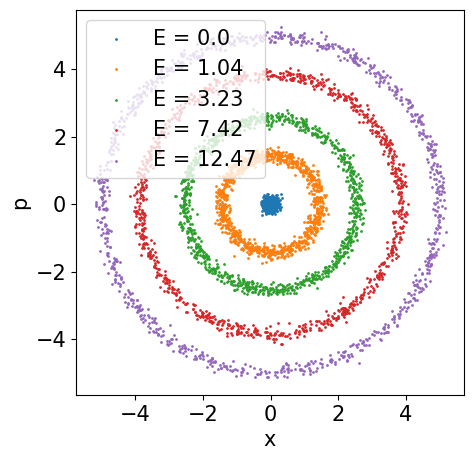

In [7]:
ho = np.load("data/harmonic_oscillator.npz")

data = ho["data"]
E = ho["E"].T[0]

plt.figure(figsize=(5, 5))
idx = np.argsort(E)[(np.arange(5) * (len(E) - 1) / 4).astype(int)]
for i in idx:
    plt.scatter(*data[i].T, label=f"E = {round(E[i], 2)}", s=1)

plt.legend()

plt.xlabel("x")
plt.ylabel("p")

plt.savefig("graphs/ho_traj.pdf")

plt.show()

In [8]:
# data = StandardScaler().fit_transform(data.reshape(data.shape[0] * data.shape[1], -1)).reshape(data.shape)
# dmat = gen_dist_matrix(data, name="data/ho")
dmat = np.load("data/ho_dmat.npz")["dmat"]

valid_size = len(dmat) // 5
train_size = len(dmat) - valid_size

train_idx, valid_idx = train_test_split(torch.arange(len(dmat)), test_size=valid_size)

dmat = torch.tensor(dmat, dtype=torch.float32)
train_dmat = dmat[train_idx[:, None], train_idx[None, :]]
valid_dmat = dmat[valid_idx[:, None], train_idx[None, :]]

In [ ]:
cfg = {
    "target_dim": 5,
    "intermediate_dim": 8,
    "intermediate_layers": 2,
}

models_ho, losses_ho = train_MSAP(train_dmat, valid_dmat, cfg, "ho_v1", min_delta=0.1, patience=50, project_name="MSAP", N_inits=2)

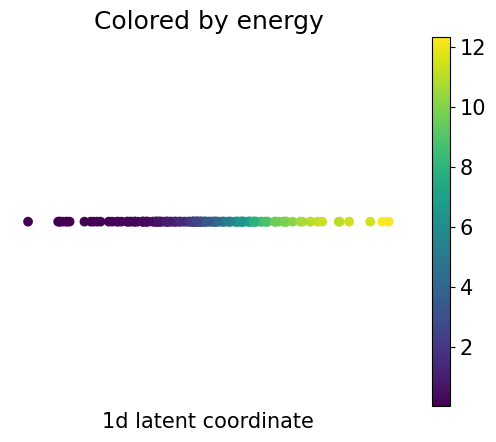

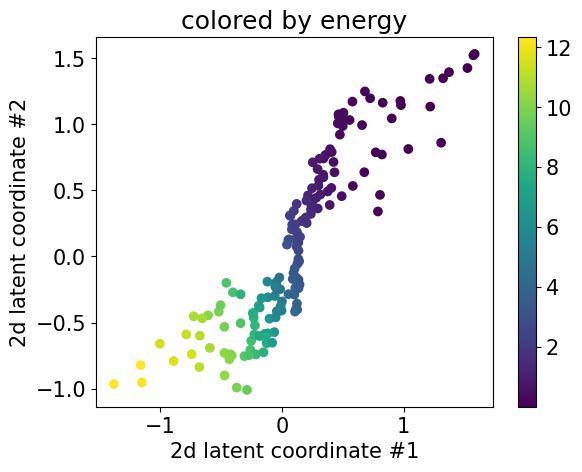

In [8]:
model1d = models_ho[0]

plt.figure()
plt.scatter(model1d.latent.cpu().detach().T[0], [np.zeros_like(train_idx)], c=E[train_idx])
plt.xlabel("1d latent coordinate")
plt.gca().yaxis.set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
plt.title("Colored by energy")
plt.colorbar()
plt.savefig("graphs/ho_latent1d.pdf")

model2d = models_ho[1]

plt.figure()
plt.scatter(*model2d.latent.cpu().detach().T, c=E[train_idx])
plt.xlabel(f"2d latent coordinate #1")
plt.ylabel(f"2d latent coordinate #2")
plt.title(f"colored by energy")
plt.colorbar()
plt.savefig("graphs/ho_latent2d.pdf")

plt.show()

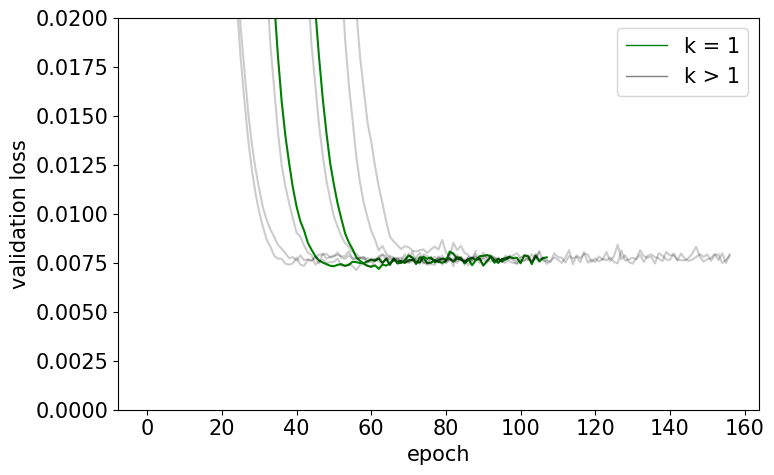

In [4]:
# to plot this graph you have to download the validation loss data from the wandb to the data folder


import pandas as pd
from matplotlib.lines import Line2D

learning_curves = pd.read_csv("data/ho_learning_curves.csv")

plt.figure(figsize=(8, 5))
epoch = learning_curves["epoch"]
for i in range(1, 5):
    c = "green" if i == 1 else "black"
    alpha = 1 if i == 1 else 0.2
    for init in range(1, 3):
        valid_loss = learning_curves[f"ho; latent_dim: {i}, init #{init} - valid_loss"]
        plt.plot(epoch, valid_loss, c=c, alpha=alpha)

custom_lines = [Line2D([0], [0], color="green", lw=1),
                Line2D([0], [0], color="gray", lw=1)]

plt.legend(custom_lines, ["k = 1", "k > 1"])

plt.ylim(0, 0.02)

plt.xlabel("epoch")
plt.ylabel("validation loss")

plt.tight_layout()

plt.savefig("graphs/ho_learning_curves.pdf", bbox_inches="tight")

plt.show()

In [11]:
N = 20

valid_size = N // 5
train_size = N - valid_size

train_idx, valid_idx = train_test_split(torch.arange(N), test_size=valid_size)

train_dmat = dmat[train_idx[:, None], train_idx[None, :]]
valid_dmat = dmat[valid_idx[:, None], train_idx[None, :]]

cfg = {
    "target_dim": 5,
    "intermediate_dim": 8,
    "intermediate_layers": 2,
    "batch_size": 8,
}

models_ho, losses_ho = train_MSAP(train_dmat, valid_dmat, cfg, "ho_small_v2", min_delta=0.1, patience=200, project_name="MSAP", N_inits=2)

latent_dim: 1
init #1


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 133   
------------------------------------
154       Trainable params
0         Non-trainable params
154       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]



best validation loss: 0.006883854512125254
------------------------------------------------------------------------




wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▅█▃▃▄▂▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
p,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r1,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇██████████████
r2,▆▆▇▇▇███████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▃▃▂▂▁
stress,▅█▃▃▄▂▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,█▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,824
loss,0.01891
p,1.1


init #2


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 133   
------------------------------------
154       Trainable params
0         Non-trainable params
154       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]



best validation loss: 0.007647745311260223
------------------------------------------------------------------------




wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
p,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r1,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇██████
r2,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇██████████▇▆▅▅▅▅▅▆▆▅▅▅▅▅▄
stress,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,999
loss,0.01577
p,1.1




best validation loss over latent dim: 0.006883854512125254
---------------------------------------------------------------------------




latent_dim: 2
init #1


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 141   
------------------------------------
182       Trainable params
0         Non-trainable params
182       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]



best validation loss: 0.0032589156180620193
------------------------------------------------------------------------




wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
p,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r1,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇███████████████
r2,▆▇▇████████▇▇▇▇▇▇▇▇▇▇▇▇▆▆▅▅▅▅▅▅▄▄▄▃▃▂▂▁▁
stress,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,753
loss,0.00965
p,1.1


init #2


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 141   
------------------------------------
182       Trainable params
0         Non-trainable params
182       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]



best validation loss: 0.006827216595411301
------------------------------------------------------------------------




wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
p,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r1,▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇██████████████████▇▇▇
r2,▇▇▇█████████████▇▇▇▇▇▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁
stress,█▄▃▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,837
loss,0.00891
p,1.1




best validation loss over latent dim: 0.0032589156180620193
---------------------------------------------------------------------------




latent_dim: 3
init #1


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 149   
------------------------------------
210       Trainable params
0         Non-trainable params
210       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]



best validation loss: 0.007202924694865942
------------------------------------------------------------------------




wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▂▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
p,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r1,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██████████████
r2,▆▇▇▇▇███████████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▁▁
stress,█▁▁▁▂▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,737
loss,0.02744
p,1.1


init #2


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 149   
------------------------------------
210       Trainable params
0         Non-trainable params
210       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]



best validation loss: 0.007110018748790026
------------------------------------------------------------------------




wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
p,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r1,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇███████████████
r2,▆▇▇▇▇▇████████████████▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁
stress,█▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,818
loss,0.02778
p,1.1




best validation loss over latent dim: 0.007110018748790026
---------------------------------------------------------------------------




latent_dim: 4
init #1


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 157   
------------------------------------
238       Trainable params
0         Non-trainable params
238       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]



best validation loss: 0.007009901572018862
------------------------------------------------------------------------




wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
p,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r1,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇██████████████▇
r2,▇▇███████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁
stress,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,796
loss,0.01863
p,1.1


init #2


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 157   
------------------------------------
238       Trainable params
0         Non-trainable params
238       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]



best validation loss: 0.005419757682830095
------------------------------------------------------------------------




wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
p,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r1,▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████████████
r2,▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████▇▇▇▇▆▆▅▅▄▄▃▃▂▁▁
stress,█▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
valid_loss,█▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,571
loss,0.01491
p,1.1




best validation loss over latent dim: 0.005419757682830095
---------------------------------------------------------------------------




